# Bottle Client Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from datetime import datetime, timedelta

## 1. Generating basic wave

Let's simulate reading every 5 minutes for 24 hours, with `t` in seconds.

In [2]:
MAX_TIME = 24*60*60

In [3]:
t = np.linspace(0, MAX_TIME, MAX_TIME//(5*60))
len(t)

288

In [4]:
def basic_wave(t, consumption):
    return (signal.square(consumption * (2 * np.pi * t) / MAX_TIME)+1) / 2

(-0.1, 1.1)

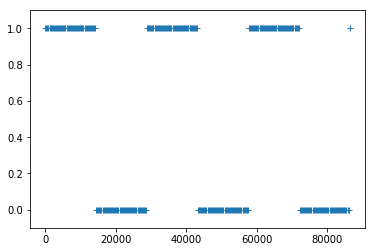

In [5]:
plt.plot(t, basic_wave(t, 3), '+')
plt.ylim(-0.1, 1.1)

## 2. Introducing noise

In [6]:
def noisy_wave(t, consumption, noise=0.05):
    return basic_wave(t, consumption) + np.random.uniform(-noise, noise, t.shape)

(-0.1, 1.1)

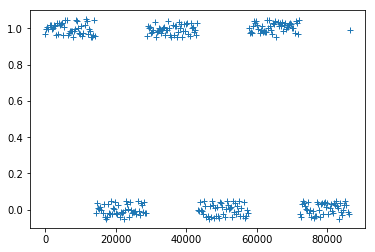

In [7]:
plt.plot(t, noisy_wave(t, 3), '+')
plt.ylim(-0.1, 1.1)

## 3. Introducing random spikes

First lets try to generate just one spike:

In [8]:
def gauss(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2.*sigma**2))

In [9]:
def gauss_spike(x):
    return gauss(x, np.random.uniform(0, MAX_TIME), MAX_TIME / np.random.uniform(20,200))

(-0.1, 1.1)

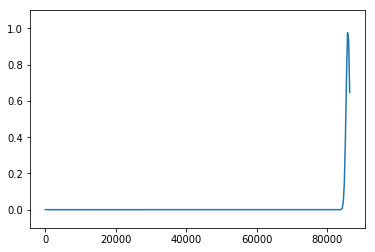

In [10]:
plt.plot(t, gauss_spike(t))
plt.ylim(-0.1, 1.1)

Now, generate n-spikes (`n` random):

In [11]:
def n_gauss_spikes(x):
    n = np.random.randint(4,12)
    result = np.zeros_like(x)
    for i in range(n):
        result += gauss_spike(x)
    return result

(-0.1, 1.1)

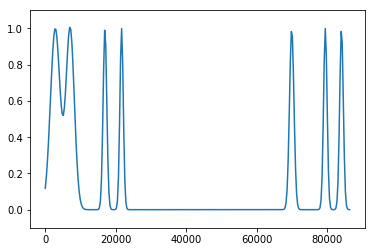

In [12]:
plt.plot(t, n_gauss_spikes(t))
plt.ylim(-0.1, 1.1)

In [13]:
def n_gauss_spikes_noise(x):
    return n_gauss_spikes(x) * np.random.uniform(-1, 1, x.shape)

(-1.1, 1.1)

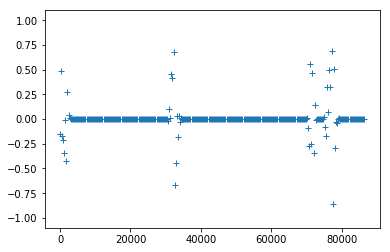

In [14]:
plt.plot(t, n_gauss_spikes_noise(t), '+')
plt.ylim(-1.1, 1.1)

Now let's introduce those spikes into our original wave:

In [15]:
def spikey_wave(t, consumption, noise=0.05):
    return noisy_wave(t, consumption, noise=noise) + n_gauss_spikes_noise(t)

In [16]:
w = spikey_wave(t, 3)

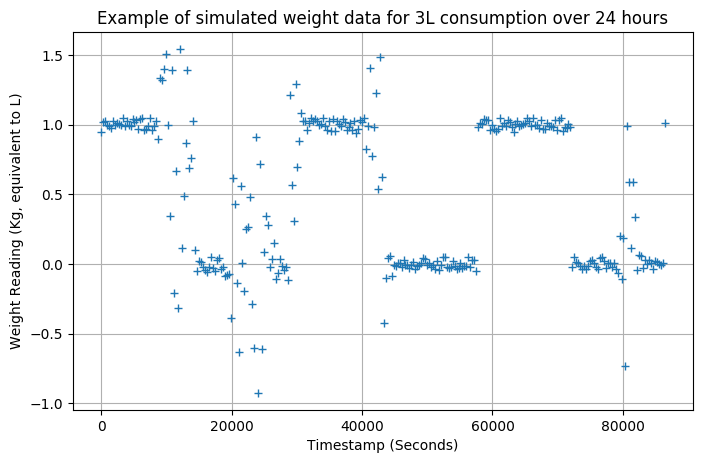

In [17]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

ax.plot(t, w, '+')
ax.set(xlabel='Timestamp (Seconds)', ylabel='Weight Reading (Kg, equivalent to L)', title='Example of simulated weight data for 3L consumption over 24 hours')
ax.grid()

fig.savefig("plots/generated-weight-data.png")
plt.show()

## 4. Generating temperatures

In [18]:
def gen_temps(t, avg_temp=20, noise=0.05):
    return np.sin(2 * np.pi * t / MAX_TIME)*2 + np.sin(3 * np.pi * t / MAX_TIME)/2 + avg_temp + np.random.uniform(-noise, noise, t.shape)

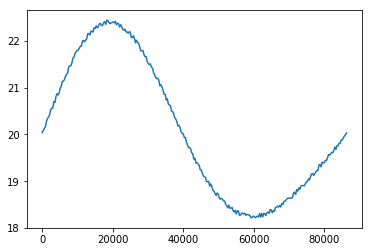

In [19]:
plt.plot(t, gen_temps(t), '-')

## 5. Final generator function

In [20]:
def gen_data(max_time=24*60*60, sample_rate=5, consumption=3, noise=0.05, temperature=20):
    start_time = datetime.timestamp(datetime.now() - timedelta(seconds=max_time))
    
    t = np.linspace(0, max_time, max_time//(sample_rate*60))
    w = spikey_wave(t, consumption, noise=noise)
    temp = gen_temps(t, avg_temp=temperature, noise=noise)
 
    return t+start_time, w, temp

In [21]:
def gen_batches(data, batch_size):
    t, w, temp = data
    
    for i in range(0, len(t), batch_size):
        yield t[i:i+batch_size], w[i:i+batch_size], temp[i:i+batch_size]

In [22]:
data = gen_data(consumption=3, temperature=20)

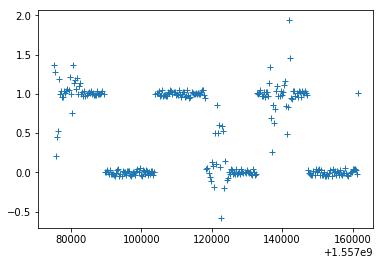

In [23]:
plt.plot(data[0],data[1],'+')

In [24]:
for t_batch, w_batch, temp_batch in gen_batches(data, 20):
    payload = {
        'data': [
            {
                'time': t_batch[i],
                'weight': w_batch[i],
                'temp': temp_batch[i]
            } for i in range(len(t_batch))
        ]
    }
    import requests, json
    r = requests.post("http://localhost:8000/api/bottleUpdate?format=json", json=payload)
    resp = json.loads(r.text)
    print(resp)

{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
{'status': 'updated', 'n_errors': 0}
